<img src="https://www.rochester.edu/assets/images/ur-logo.svg">

# <center>[CSC 249/449: Machine Vision](https://www.cs.rochester.edu/~cxu22/t/249F20/)</center>

## Homework Submission
After completed the homework notebook. 
- Make sure you fill in any place that says `YOUR CODE HERE` or `YOUR ANSWER HERE`, as well as your NetID below.
- `Kernel`$\rightarrow$ `Restart & Run All` (in the menubar).
- You can generated zip file using following command:
    ```python
    NetID=''
    make_submission(NetID)
    ```
- Double-check **generated zip file**, text, math, code, outputs, figures. Re-run if needed.
- Sumbit the zip file via blackboard.
- 1% deduction of late assignment total score per hour passing the deadline.
---------


## Part 3. Image Stiching
----
Image 1 | Image 2
- | - 
<img src="data/left.png" height="350"/>| <img src="data/right.png" height="350"/>

In [1]:
from cs249 import *

In [2]:
img1 = cv2.cvtColor(cv2.imread(str(data/'left.png')), cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(cv2.imread(str(data/'right.png')), cv2.COLOR_BGR2RGB)

# Problem 3.1 Feature detection 
For each point in the image, consider a window of pixels around that point.  Compute the Harris matrix H for (the window around) that point, defined as
$$
H=w \circledast \left[\begin{array}{cc}
\nabla^2_xI & \nabla_xI\nabla_yI  \\
\nabla_xI\nabla_yI & \nabla^2_yI
\end{array}\right]\\
$$
We then compute the corner strength function

$$
c(H)=\det(H)-0.1\cdot(\operatorname{trace}(H))^2\\
$$

In [20]:
# return list of keypoints with cv2.KeyPoint() datatype and use 1 for diameter size
# https://docs.opencv.org/2.4/modules/features2d/doc/common_interfaces_of_feature_detectors.html
# https://muthu.co/harris-corner-detector-implementation-in-python/
import cv2
from scipy import signal as sig
from scipy.signal import argrelextrema
import scipy as sp
import numpy as np

def feature_detection(gray, alpha, threshold):
    
    # Step one: Image derivatives in x and y directions
    kernel_x = np.array([[-0.125, 0, 0.125],[-0.25, 0, 0.25],[-0.125, 0, 0.125]])
    I_x = cv2.filter2D(gray,-1,kernel_x)
    kernel_y = np.array([[0.125, 0.25, 0.125], [0, 0, 0], [-0.125,-0.25,-0.125]])
    I_y = cv2.filter2D(gray,-1,kernel_y)
    
    # Step two: Apply Gaussian Filter to Ixx, Iyy, and Ix*Iy
    Ixx = cv2.GaussianBlur(I_x**2, (3,3), 2 )
    Ixy = cv2.GaussianBlur(I_y*I_x, (3,3), 2 )
    Iyy = cv2.GaussianBlur(I_y**2, (3,3), 2 )
    
    
    # Step three: Compute corner strength function
    det_H = Ixx * Iyy - Ixy ** 2
    trace_H = Ixx + Iyy
    Harris_response = det_H - alpha * trace_H**2
    
    # Step four: Non-maxima Suppression 
    # choose key points that are local maxima and larger than threshold * global maxima
    index_set = np.argwhere(Harris_response > Harris_response.max() * threshold)
    maximums = argrelextrema(gray, np.greater,order=30)
    local_max=[]
    for i in range(len(maximums[0])):
         local_max.append([maximums[0][i],maximums[1][i]])
    kp = []
    for m,n in index_set:
        if [m,n] in local_max:
            kp.append(cv2.KeyPoint(int(n),int(m),_size=1))
    #3*3 window find local maxima
    # for pt in index_set:
    #    x = pt[0]
    #    y = pt[1]
    #    if (y >= 2 and y <= Harris_response.shape[0]-2) and (x >=2 and x <= Harris_response.shape[1]-2):
    #        if Harris_response[y,x] >= np.max(Harris_response[y-2:y+2,x-2:x+2]):
    #            kp.append(cv2.KeyPoint(int(y),int(x),_size=1))
    
    return kp

### Problem 3.2 Feature description

In [21]:
kp1= feature_detection(cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY),0.04,0.2)
kp2= feature_detection(cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY),0.04,0.2)
sift = cv2.SIFT_create()
k1, d1 = sift.compute(img1,kp1)
k2, d2 = sift.compute(img2,kp2)

In [23]:
len(kp1)

5365

### Problem 3.3 Feature matching
#### a. k-nearest neibors

In [25]:
# return list of k-nearest neibors with cv2.DMatch datatype and use 1 for diameter size
# https://docs.opencv.org/2.4/modules/features2d/doc/common_interfaces_of_descriptor_matchers.html?highlight=dmatch

def knn(query,train,k):
    matches = []
    distances = []
    for i in range(len(query)):
        for j in range(len(train)):
            dist = np.linalg.norm(query[i]-train[j])
            distances.append((j, dist))
        distances.sort(key=lambda tup: tup[1])
        m=0
        while m < k:
            matches.append(cv2.DMatch(_queryIdx=i,_trainIdx=distances[m][0],_distance=distances[m][1]))
            m=m+1
    return matches

In [ ]:
# if distance of the first neibor < ratio* second neibor, then we think this match is good
# b. compare the distance ratio and only choose good matches
matches=knn(query=d1,train=d2,k=2)
ratio = 0.7
good_matches = []
i=0
while i < len(matches):
    if matches[i].distance < ratio * matches[i+1].distance:
        good_matches.append(matches[i])
    i = i+2
good_matches

#### c. display the good matches

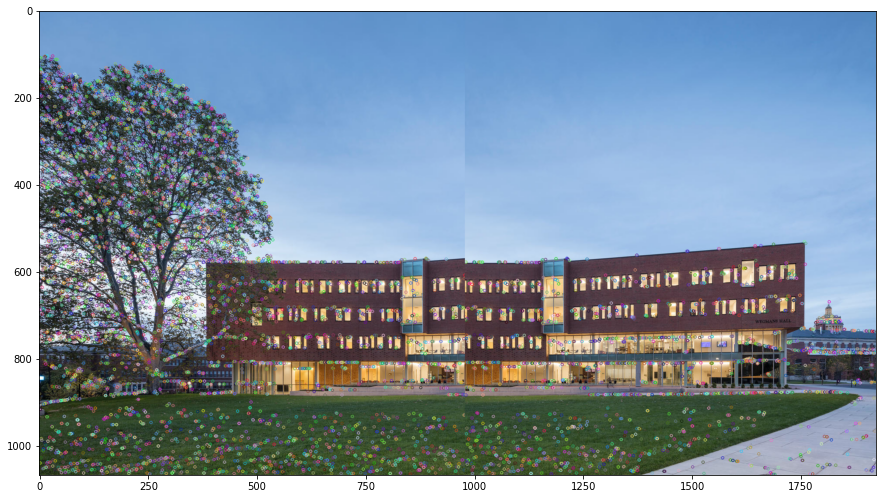

In [24]:
img3 = cv2.drawMatches(img1,kp1,img2,kp2,good_matches,None)
plt.figure(figsize = (15,20))
plt.imshow(img3)
plt.show()

# NetID: yfan24
Student: Yangxin Fan

### Stiching will be in the next assignment